# Preliminary Analysis of OpenStreetMap Data for Yukon Territory

As a first step, we aimed to replicate the work done by [Diego Matos Chavez (2020)](https://medium.com/data-science/estimating-the-population-of-arbitrarily-chosen-areas-533e81c2104e), where OSM data was used to estimate the population of London. The author created a command-line application that performs feature extraction on OpenStreetMap (OSM) data. 

## Data preparation


### OSM Data

First, we will inspect the data downloaded from the [OSM export tool](https://export.hotosm.org/v3/). For a specified area, this tool outputs OSM data in a variety of formats: GeoJSON, GPKG, SHP, and OSM.PBF. 

While the tool also exports a clipping boundary, this is not exactly the territorial boundary. As such, a GeoJSON of the territorial boundary was downloaded from [Open Data Soft](https://data.opendatasoft.com/explore/dataset/georef-canada-province%40public/export/?disjunctive.prov_name_en) and was used to clip the OSM data to the precise territorial boundary. 

In [3]:
# Import packages 

import geopandas as gpd
import pandas as pd 
import matplotlib.pyplot as plt
from shapely.geometry import shape
import json
import contextily as ctx
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import math
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import LeaveOneOut
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from population_geojson import process_lines, format_lines, load_and_clean_geojson
from model_dev import prepare_data, compare_models



In [ ]:
# Scrape data from PDF
pdf_path = "Data/fin-population-estimates-census-subdivision-2019-to-2022.pdf"
lines = process_lines(pdf_path)
pop_df = format_lines(lines)

# Save to CSV
pop_df.to_csv("Data/yukon_population_estimates_cleaned.csv", index=False)

# Save 2022 data
pop_2021 = pop_df[["Subdivision", "2021"]].copy()
pop_2021.rename(columns={"2021":"population"}, inplace=True)
pop_2021 = pop_2021[pop_2021["Subdivision"] != "Yukon"]


In [65]:
# Load geopackage data
gdf = gpd.read_file("Data/OSM_exports/Yukon_gpkg_uid_9cf9d9be-ab7a-413b-8de5-50db2e3aa7f2/Yukon.gpkg")

# Load territorial boundary
with open("Data/georef-canada-province@public.geojson") as f:
    boundary_data = json.load(f)
boundary_poly = shape(boundary_data['features'][0]['geometry'])

# Convert to a GeoDataFrame
boundary_gdf = gpd.GeoDataFrame(index=[0], geometry=[boundary_poly], crs="EPSG:4326")

# Clip the original GeoDataFrame to the boundary
gdf_clipped = gpd.clip(gdf, boundary_gdf)

# Save clipped gdf as geojson
gdf_clipped.to_file("Data/clipped_data/clipped_geojson.geojson", driver="GeoJSON")

# Create smaller gdfs for interactive map
gdf_clipped_points = gdf_clipped[gdf_clipped.geometry.type == "Point"]
gdf_clipped_points.to_file("Data/clipped_data/clipped_points.geojson", driver="GeoJSON")
gdf_clipped_line = gdf_clipped[gdf_clipped.geometry.type == "LineString"]
gdf_clipped_line.to_file("Data/clipped_data/clipped_lines.geojson", driver="GeoJSON")
gdf_clipped_multiline = gdf_clipped[gdf_clipped.geometry.type == "MultiLineString"]
gdf_clipped_multiline.to_file("Data/clipped_data/clipped_multilines.geojson", driver="GeoJSON")
gdf_clipped_poly = gdf_clipped[gdf_clipped.geometry.type == "Polygon"]
gdf_clipped_poly.to_file("Data/clipped_data/clipped_multipoly.geojson", driver="GeoJSON")
gdf_clipped_multipoly = gdf_clipped[gdf_clipped.geometry.type == "MultiPolygon"]
gdf_clipped_multipoly.to_file("Data/clipped_data/clipped_multipoly.geojson", driver="GeoJSON")
gdf_clipped_buildings = gdf_clipped[gdf_clipped["building"].notnull()]
gdf_clipped_buildings.to_file("Data/clipped_data/clipped_buildings.geojson", driver="GeoJSON")

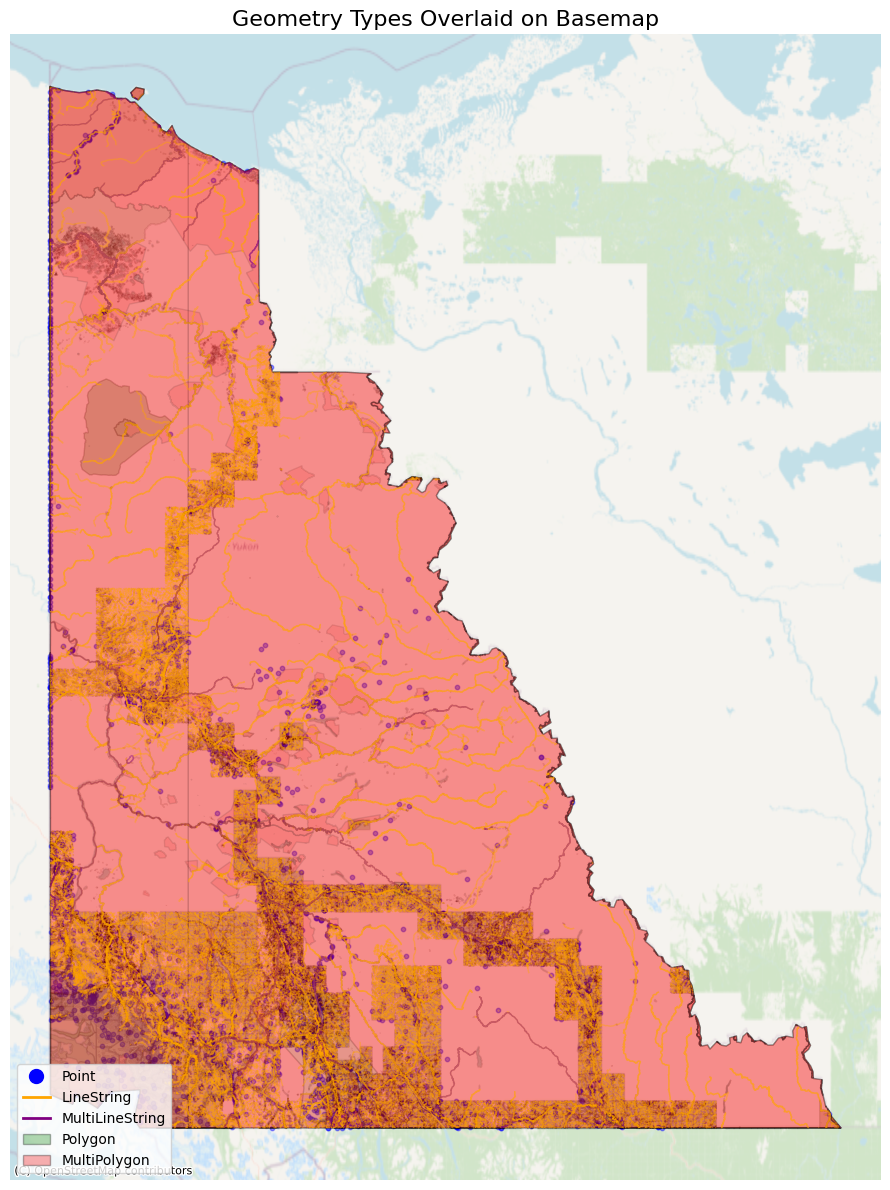

In [67]:
# Plot different geometries with different colors

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 12))

# Plot geometries with transparency
gdf_clipped[gdf_clipped.geometry.type == 'Point'].plot(ax=ax, color='blue', markersize=10, alpha=0.4)
gdf_clipped[gdf_clipped.geometry.type == 'LineString'].plot(ax=ax, color='orange', linewidth=1, alpha=0.4)
gdf_clipped[gdf_clipped.geometry.type == 'MultiLineString'].plot(ax=ax, color='purple', linewidth=1, alpha=0.4)
gdf_clipped[gdf_clipped.geometry.type == 'Polygon'].plot(ax=ax, facecolor='green', edgecolor='black', alpha=0.1)
gdf_clipped[gdf_clipped.geometry.type == 'MultiPolygon'].plot(ax=ax, facecolor='red', edgecolor='black', alpha=0.1)

# Add basemap
ctx.add_basemap(ax, crs=gdf_clipped.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.7)

# Build custom legend
legend_handles = [
    mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=10, label='Point'),
    mlines.Line2D([], [], color='orange', linewidth=2, label='LineString'),
    mlines.Line2D([], [], color='purple', linewidth=2, label='MultiLineString'),
    mpatches.Patch(facecolor='green', edgecolor='black', alpha=0.3, label='Polygon'),
    mpatches.Patch(facecolor='red', edgecolor='black', alpha=0.3, label='MultiPolygon')
]

ax.legend(handles=legend_handles, loc='lower left')
ax.set_title("Geometry Types Overlaid on Basemap", fontsize=16)
ax.set_axis_off()

plt.tight_layout()
plt.show()

OSM defines data using three basic elements: nodes, ways, and relations. A **node** represents single location, defined by coordinates. Nodes often represent standalone features, like a water fountain or a tree. A **way** is a series of connected nodes. If a way is comprised of an unenclosed series of nodes, it can be used to represent linear features like roads or rivers. If the series of nodes is enclosed, it forms a **closed way** which represents the boundary of an area. Closed ways denote features like buildings or parks. Finally, **relations** define a relationship between two or more elements (nodes, ways, or other relations). Relations may include a collection of ways that form a bus route, or some area with an outer boundary but holes in the middle. 

OSM data structures are in line with traditional GIS data. Nodes are equivalent to **points**, and unenclosed ways are similar to **linestrings** and **multi-line strings**. Enclosed ways defining an area are represented as **polygons**, whereas areas with holes are represented as **multipolygons**. A table defining the relationships can be found below. 

| GIS | OSM | Example from Yukon Data |
| --- | --- | --- |
| Point | Node | Ottawa Glacier |
| LineString | Unenclosed Way | Spring Creek |
| MultiLineString | Unenclosed Way | Service highway |
| Polygon | Closed Way | Donjek Lakes |
| MultiPolygon | Relation | Stikine Region |


### Merging Population Counts with Geospatial Data

The `osm-feature-extractor` command-line application requires a GeoJSON with sub-divided areas and their known populations. Therefore, the next step of the analysis was to create a file meeting these specifications.  


Population counts for the census subdivisions from 2019-2022 are contained in a [PDF](https://yukon.ca/sites/default/files/ybs/fin-population-estimates-census-subdivision-2019-to-2022.pdf) on the Yukon.ca official website. A csv was created to store this information in a more usable format. Data from 2021 was used, as this was the last federal census. 

In [68]:
# Scrape data from PDF
pdf_path = "Data/fin-population-estimates-census-subdivision-2019-to-2022.pdf"
lines = process_lines(pdf_path)
pop_df = format_lines(lines)

# Save to CSV
pop_df.to_csv("Data/yukon_population_estimates_cleaned.csv", index=False)


pop_20# Save 2021 data
pop_2021 = pop_df[["Subdivision", "2021"]].copy()
pop_2021.rename(columns={"2021":"population"}, inplace=True)21 = pop_2021[~pop_2021["Subdivision"].str.contains("Yukon")]

# Add organized and unorganized together for Whitehorse
wh_org = pop_2021[pop_2021["Subdivision"] == "Whitehorse"]["population"].values[0]
wh_unorg = pop_2021[pop_2021["Subdivision"] == "Whitehorse, Unorganized"]["population"].values[0]

# Remove the original rows for Whitehorse, Organized and Unorganized
pop_2021 = pop_2021[~pop_2021["Subdivision"].isin(["Whitehorse", "Whitehorse, Unorganized"])]

# Create a new DataFrame for the combined Whitehorse population
wh_total = pd.DataFrame([{"Subdivision": "Whitehorse", "population": wh_org + wh_unorg}])

# Add the new row to the DataFrame using pd.concat()
pop_2021 = pd.concat([pop_2021, wh_total], ignore_index=True)

# Display the updated DataFrame
print(pop_2021)


                                   Subdivision  population
0                                 Beaver Creek         108
1                              Burwash Landing          92
2                                     Carcross         412
3                                   Carcross 4          40
4                                     Carmacks         552
5                         Champagne Landing 10          26
6                                       Dawson        1728
7                              Destruction Bay          42
8                                         Faro         445
9                              Haines Junction         785
10                                 Ibex Valley         499
11                           Johnsons Crossing          12
12                                   Keno Hill          21
13                              Lake Laberge 1          18
14                   Macpherson-Grizzly Valley        1532
15                                  Marsh Lake         7

Then, a GeoJSON of the census subdivisions was downloaded, again from [Open Data Soft](https://public.opendatasoft.com/explore/dataset/georef-canada-census-subdivision/table/?disjunctive.prov_name_en&disjunctive.cd_name_en&disjunctive.csd_name_en&refine.prov_name_en=Yukon). 

In [87]:
# Load census subdivisions GEOJSON
sub_gdf = load_and_clean_geojson("Data/georef-canada-census-subdivision@public.geojson")

# Load territorial boundary, for mapping
territorial_boundary = load_and_clean_geojson("Data/georef-canada-province@public.geojson")


Finally, the spatial data was merged with the population data. 

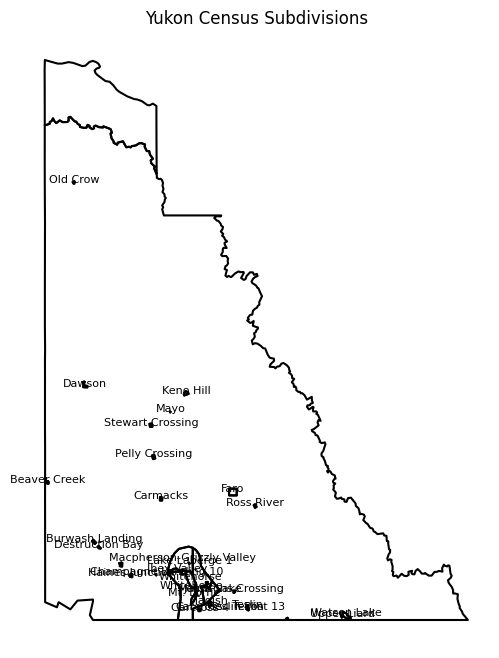

In [88]:
# Add 2021 population to subdivision geojson

# Create a version that has all subdivisions, even those missing population data. 
# Perhaps later on we can predict populations in these areas. 
merged_total = sub_gdf.merge(pop_2021, how="left", left_on="csd_name_en", right_on="Subdivision")

# For modelling, create a version with no missing data using an inner join.
merged_inner = sub_gdf.merge(pop_2021, how="inner", left_on="csd_name_en", right_on="Subdivision")


# Plot just the subdivisions
fig, ax = plt.subplots(figsize=(12, 8))
merged_inner.plot(
    edgecolor="black",       # Outline all subdivisions
    facecolor="none",        # No fill color
    linewidth=0.8,           # Adjust border thickness
    ax=ax
)
# Plot the territorial boundary
territorial_boundary.plot(
    edgecolor="black",         # Outline the boundary in red
    facecolor="none",        # No fill color
    linewidth=1.5,           # Adjust border thickness
    ax=ax
)

# Add subdivision names as labels
for idx, row in merged_inner.iterrows():
    # Use the centroid of each geometry for label placement
    centroid = row.geometry.centroid
    ax.text(
        centroid.x, centroid.y, 
        row["Subdivision"],     # Replace with the column containing subdivision names
        fontsize=8, 
        ha="center"
    )

plt.title("Yukon Census Subdivisions")
plt.axis("off")
plt.show()


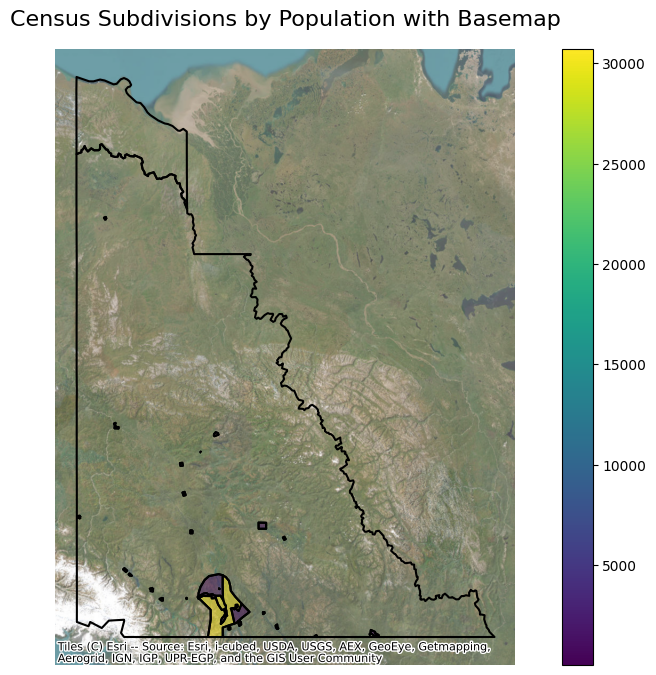

In [89]:
# Plot the census subdivisions
merged_web_mercator = merged_inner.to_crs(epsg=3857)
territorial_boundary_proj = territorial_boundary.to_crs(epsg=3857)


fig, ax = plt.subplots(figsize=(12, 8))
merged_web_mercator.plot(
    column="population",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.5,
    alpha=0.5,                        # Transparency for all polygons
    ax=ax,
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "black",
        "hatch": "///",
        "label": "No data"
    }
)

# Plot the territorial boundary
territorial_boundary_proj.plot(
    edgecolor="black",         # Outline the boundary in red
    facecolor="none",        # No fill color
    linewidth=1.5,           # Adjust border thickness
    ax=ax
)

# Add a basemap 
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, alpha=0.7)

# Add title and remove axes
plt.title("Census Subdivisions by Population with Basemap", fontsize=16)
plt.axis("off")

plt.show()

In [90]:
# Save data
merged_total.to_file("Data/sub_population_full.geojson", driver="GeoJSON")
merged_inner.to_file("Data/sub_population_inner.geojson", driver="GeoJSON")

## EDA

### Correlation Analysis

After creating the GeoJSON with population data, we can use the `osm-feature-extractor` tool and save the output. This was done command-line. 

Now, replicating the work done by Matos Chavez, we will investigate the correlation each OSM variable has with the target (population). 

In [4]:
# Read the GeoDataFrame
gdf = gpd.read_file("Data/osm_extractor_output")

# Remove Yukon from the output
gdf = gdf[gdf["Subdivision"] != "Yukon"]

# Combine rows for Whitehorse by summing numeric features
gdf["Subdivision"] = gdf["Subdivision"].replace(
    {"Whitehorse, Organized": "Whitehorse", "Whitehorse, Unorganized": "Whitehorse"}
)

# Group by Subdivision and sum numeric features
gdf_combined = gdf.groupby("Subdivision", as_index=False).sum(numeric_only=True)


gdf_combined = gdf.groupby("Subdivision", as_index=False).agg({
    **{col: "sum" for col in gdf.select_dtypes(include="number").columns},  
    **{col: "first" for col in gdf.select_dtypes(exclude="number").columns}  
})


In [94]:

# Calculate correlations with the target
correlations = gdf_combined.corr(numeric_only=True)["population"].sort_values(ascending=False)
# Drop population, since correlation will be 1. 
correlations = correlations.drop(index=["population"])
# Convert to DF for plotting
correlations_df = correlations.reset_index()
correlations_df.dropna(inplace=True)
correlations_df.columns = ["Feature", "Correlation"]

In [95]:
correlations_df

,Feature,Correlation
0,natural_count,0.999420
1,shop_other_area,0.999317
2,craft_count,0.999261
3,railway_tram_length,0.999261
4,railway_tram_stop_count,0.999261
...,...,...
98,highway_primary_length,0.000125
99,public_transport_station_count,-0.036790
100,railway_station_count,-0.036790
101,shop_hobbies_area,-0.037410


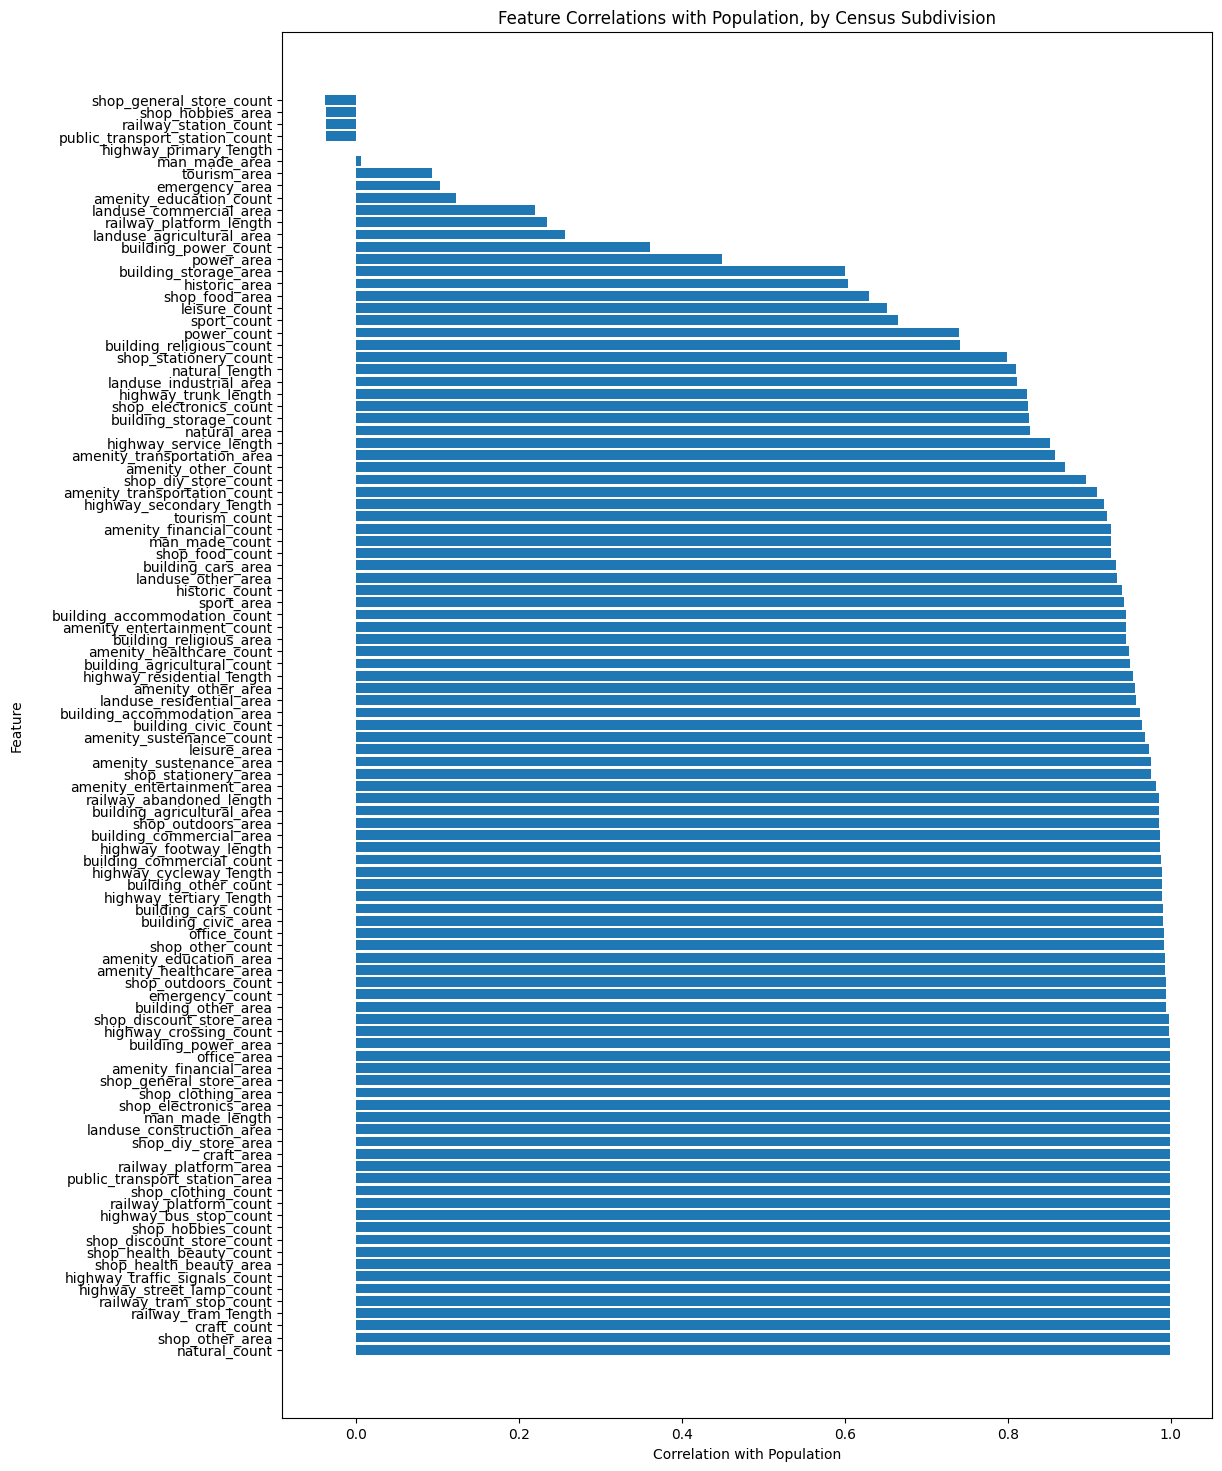

In [96]:
fig, ax = plt.subplots(figsize=(12, 18))

ax.barh(correlations_df["Feature"], correlations_df["Correlation"], height=0.8)
plt.xlabel("Correlation with Population")
plt.ylabel("Feature")
plt.title("Feature Correlations with Population, by Census Subdivision")
# Increase space between y-axis ticks
ax.yaxis.labelpad = 20  # Adjust this value as needed

plt.show()


### Feature relationships

In [98]:
def make_scatterplots(df, target_var):
    """Makes scatterplots comparing each variable in df to target_var.
    Parameters:
        df: geodf
        target_var: name of target, string
    """
    features = [col for col in df.columns if col!= target_var and col != "Subdivision"]
    rows = math.ceil(len(features)/4)
    fig, axes = plt.subplots(rows, 4, figsize=(4*5, rows*4), constrained_layout=True)
    axes=axes.flatten()
    for i, feature in enumerate(features):
        ax = axes[i]
        ax.scatter(df[feature], df[target_var], alpha=0.7, edgecolor='k')
        ax.set_title(f"{feature} vs {target_var}", fontsize=10)
        ax.set_xlabel(feature, fontsize=8)
        ax.set_ylabel(target_var, fontsize=8)
        ax.grid(True, linestyle='--', alpha=0.5)
    plt.suptitle(f"Scatter Plots: Features vs {target_var}", fontsize=16)
    plt.show()



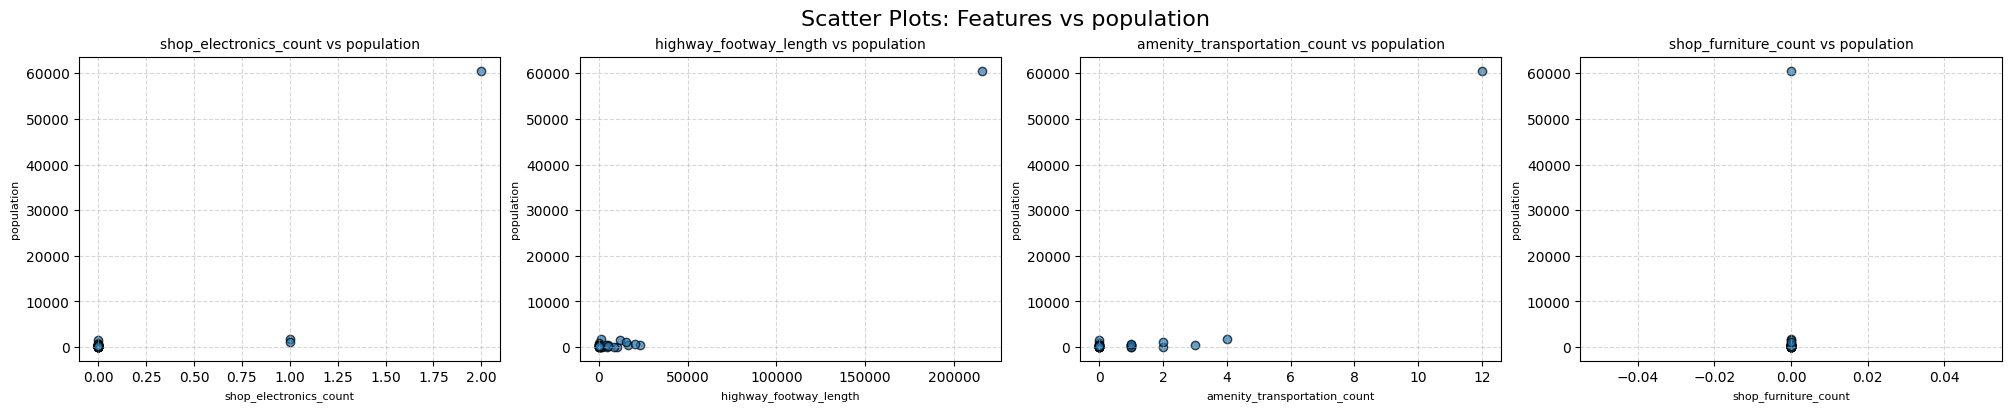

In [99]:
subset = gdf_combined[["shop_electronics_count", "highway_footway_length", "amenity_transportation_count", "shop_furniture_count", "population"]]
make_scatterplots(subset, "population")

The graphs above demonstrate the most prevalent patterns found in the data. While some features like `highway_footway_length` demonstrate linear relationships, others like `shop_electronics_count` or `amenity_transportation_count` display more curved (quadratic or cubic) relationships. Some variables, like `shop_furniture_count` are constantly 0.

### Visualizing spatially

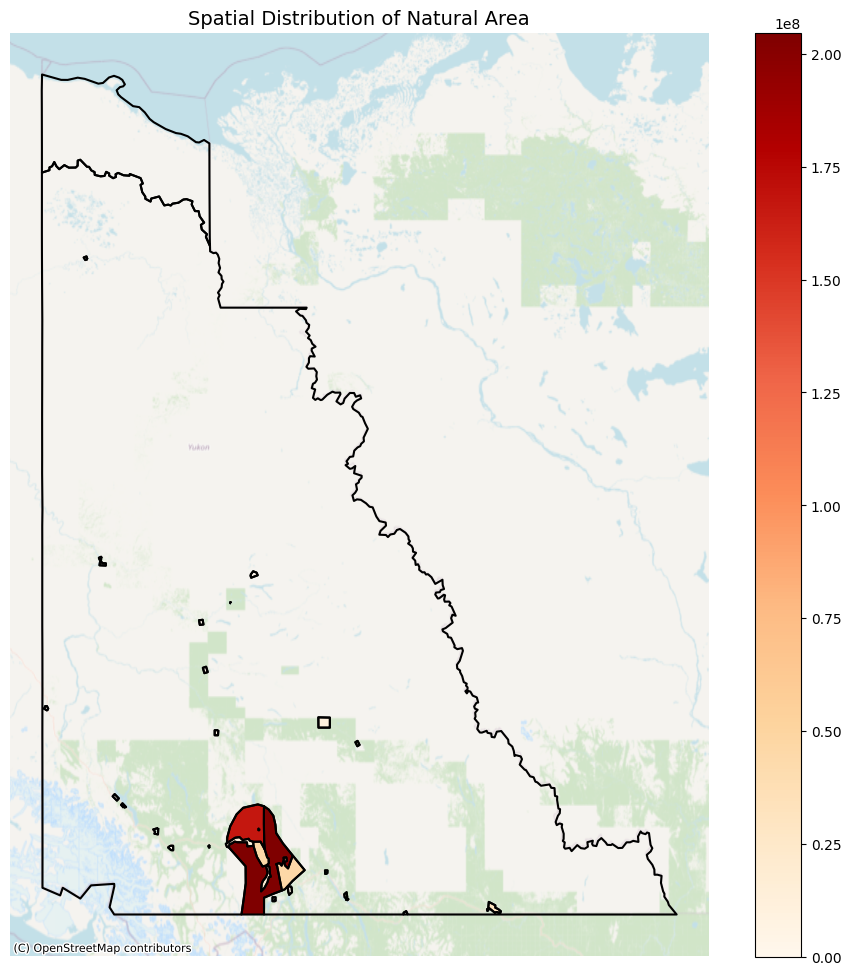

In [101]:
feature = "natural_area"
fig, ax = plt.subplots(figsize=(12, 12))
gdf.plot(
    column=feature,
    cmap="OrRd",   
    legend=True,
    edgecolor="black",
    linewidth=0.1,
    ax = ax, 
    figsize=(10, 8)
)

# Plot the territorial boundary
territorial_boundary.plot(
    edgecolor="black",         # Outline the boundary in red
    facecolor="none",        # No fill color
    linewidth=1.5,           # Adjust border thickness
    ax=ax
)

# Add a basemap 
ctx.add_basemap(ax, crs=gdf_clipped.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.7)

plt.title(f"Spatial Distribution of {feature.replace('_', ' ').title()}", fontsize=14)
plt.axis("off")
plt.show()

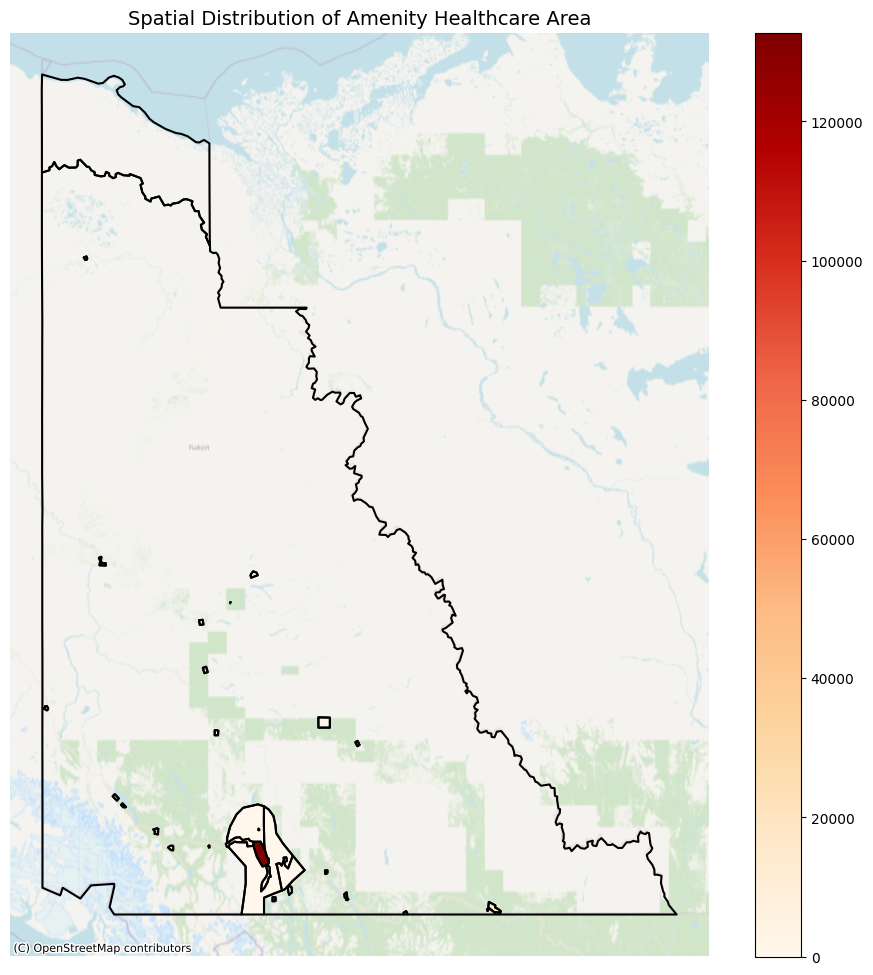

In [102]:
feature = "amenity_healthcare_area"
fig, ax = plt.subplots(figsize=(12, 12))
gdf.plot(
    column=feature,
    cmap="OrRd",   
    legend=True,
    edgecolor="black",
    linewidth=0.1,
    ax = ax, 
    figsize=(10, 8)
)

# Plot the territorial boundary
territorial_boundary.plot(
    edgecolor="black",         # Outline the boundary in red
    facecolor="none",        # No fill color
    linewidth=1.5,           # Adjust border thickness
    ax=ax
)

# Add a basemap 
ctx.add_basemap(ax, crs=gdf_clipped.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.7)

plt.title(f"Spatial Distribution of {feature.replace('_', ' ').title()}", fontsize=14)
plt.axis("off")
plt.show()

## Regression

In [109]:
gdf = gpd.read_file("Data/osm_extractor_output")


cols_to_remove = ["geo_point_2d",
                "year",
                "prov_code",
                "prov_name_en",
                "cd_code",
                "cd_name_en",
                "csd_code",
                "csd_name_en",
                "csd_area_code",
                "csd_type",
                "prov_name_fr",
                "cd_name_fr",
                "csd_name_fr",
                "Subdivision",
                "updated",
                "geometry"]
gdf_norm, areas, subdivisions = prepare_data(gdf, cols_to_remove, crs='epsg:3857')


In [82]:
# Leave-One-Out CV
loo = LeaveOneOut()

regressors = {
    'LinearRegression': LinearRegression(),
    'RidgeCV': RidgeCV(alphas=[0.01, 0.1, 1, 10, 100], cv=loo),
    'LassoCV': LassoCV(alphas=[0.001, 0.01, 0.1, 1, 10], cv=loo, max_iter=10000),
    'ElasticNetCV': ElasticNetCV(alphas=[0.001, 0.01, 0.1, 1, 10],
                                    l1_ratio=[0.1, 0.5, 0.9],
                                    cv=loo,
                                    max_iter=10000),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
                                                    max_depth=3, random_state=42)
}

results = compare_models(regressors, gdf_norm, degrees=[1, 2])
results

,Regressor,Polynomial Degree,MAE,MSE,Converged,Warning,Best Params
5,LassoCV,2,1.823829,5.062061e+00,True,None,alpha=1.0
4,LassoCV,1,2.213849,8.322478e+00,True,None,alpha=1.0
11,GradientBoosting,2,3.591331,6.127453e+01,True,None,None
9,RandomForest,2,3.669299,4.882446e+01,True,None,None
8,RandomForest,1,3.834723,5.012447e+01,True,None,None
10,GradientBoosting,1,3.975979,6.209388e+01,True,None,None
2,RidgeCV,1,5.556546,1.008990e+02,False,UserWarning,None
3,RidgeCV,2,5.556546,1.008990e+02,False,UserWarning,None
6,ElasticNetCV,1,5.556546,1.008990e+02,False,ConvergenceWarning,None
7,ElasticNetCV,2,5.556546,1.008990e+02,False,ConvergenceWarning,None


Now we will find the predictions for each subdivision, using best model. 

In [83]:
y = gdf_norm["population_density"]
X = gdf_norm.drop(columns=["population_density"])

best_mod = Lasso(alpha=1)

pipeline = Pipeline([
                ("poly", PolynomialFeatures(degree=2, include_bias=False)),  # Add polynomial terms
                ("scaler", StandardScaler()),  # Ensure scaling after polynomial transformation
                ("regressor", best_mod)
            ])

pipeline.fit(X, y)



Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('scaler', StandardScaler()), ('regressor', Lasso(alpha=1))])

In [84]:
y_pred = pipeline.predict(X)
pred_counts = y_pred * areas
actual_counts = gdf[gdf["Subdivision"]!="Yukon"]["population"]  


In [86]:
pred_df = {"Subdivision": subdivisions, 
           "Predicted": pred_counts.round(2), 
           "Actual": actual_counts}
pred_df = pd.DataFrame(pred_df)
pred_df["AbsDifference"] = round(abs(pred_df["Predicted"] - pred_df["Actual"]), 2)
pred_df = pred_df.sort_values(by="AbsDifference", ascending=False)
pred_df

,Subdivision,Predicted,Actual,AbsDifference
22,Macpherson-Grizzly Valley,14189.13,1532,12657.13
27,Marsh Lake,6466.35,744,5722.35
12,Whitehorse,25501.80,30269,4767.20
3,Whitehorse,33293.78,30269,3024.78
7,Ibex Valley,2008.28,499,1509.28
0,Faro,1805.28,445,1360.28
29,Watson Lake,1969.44,1051,918.44
8,Mt. Lorne,1286.88,466,820.88
16,Keno Hill,393.55,21,372.55
10,Dawson,1424.20,1728,303.80
